In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.signal as signal
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from astropy.stats import gaussian_sigma_to_fwhm,gaussian_fwhm_to_sigma

import datetime
import pickle
import importlib
import json
import time
import glob

from time_converter import time_converter
from gaussian_fit_eve import gaussian_fit_eve


In [2]:
with open('data/selected_band.pkl','rb') as f:
    selected_band = pickle.load(f)

wavelength_full = np.load('data/wavelength_full.npz')['wavelength_full']


In [3]:
selected_band

,Line Name,Wavelength Range,Initial Guess,Wavelength Index
0,X148,"[14.75, 14.93]","[0.00011, 14.84, 0.0424]","[588, 589, 590, 591, 592, 593, 594, 595, 596]"
1,X150,"[14.93, 15.09]","[4.4e-05, 15.01, 0.0424]","[597, 598, 599, 600, 601, 602, 603, 604]"
2,X152,"[15.13, 15.35]","[6.5e-05, 15.22, 0.0424]","[607, 608, 609, 610, 611, 612, 613, 614, 615, ..."
3,X154,"[15.35, 15.53]","[4e-05, 15.42, 0.0424]","[618, 619, 620, 621, 622, 623, 624, 625, 626]"
4,Fe171,"[17, 17.21]","[0.0006, 17.11, 0.0424]","[700, 701, 702, 703, 704, 705, 706, 707, 708, ..."
5,X174,"[17.37, 17.59]","[0.00069, 17.45, 0.0424]","[719, 720, 721, 722, 723, 724, 725, 726, 727, ..."
6,X176,"[17.63, 17.83]","[0.00045, 17.72, 0.0424]","[732, 733, 734, 735, 736, 737, 738, 739, 740, ..."
7,Fe180,"[17.95, 18.15]","[0.0006, 18.05, 0.0424]","[748, 749, 750, 751, 752, 753, 754, 755, 756, ..."
8,X182,"[18.15, 18.31]","[0.00013, 18.22, 0.0424]","[758, 759, 760, 761, 762, 763, 764, 765]"
9,X185,"[18.35, 18.59]","[0.0002, 18.45, 0.0424]","[768, 769, 770, 771, 772, 773, 774, 775, 776, ..."


In [4]:
selected_band.iloc[13]

Line Name                                              Fe180
Wavelength Range                              [19.43, 19.59]
Initial Guess                        [0.0006, 18.05, 0.0424]
Wavelength Index    [822, 823, 824, 825, 826, 827, 828, 829]
Name: 13, dtype: object

In [6]:
band_index = 13
with open('./data/original_df/original_df_'+selected_band.loc[band_index]['Line Name']+'.pkl', 'rb') as file:
    original_df = pickle.load(file)

In [7]:
original_df

,irradiance
time,
2010-04-30 00:00:00,"[5.7781443e-05, 0.00014983359, 0.00029976433, ..."
2010-04-30 00:00:10,"[5.9127276e-05, 0.00015344011, 0.00030306668, ..."
2010-04-30 00:00:20,"[5.776478e-05, 0.00015231254, 0.0003045721, 0...."
2010-04-30 00:00:30,"[5.7067216e-05, 0.00015057094, 0.00030168178, ..."
2010-04-30 00:00:40,"[5.8380378e-05, 0.00015312729, 0.00030315295, ..."
...,...
2014-05-25 23:59:19,"[9.675366e-05, 0.00026411822, 0.00048199017, 0..."
2014-05-25 23:59:29,"[9.542235e-05, 0.00026194088, 0.00047475315, 0..."
2014-05-25 23:59:39,"[9.474796e-05, 0.00026330765, 0.0004738663, 0...."


In [3]:
band_index = 7
with open('./data/fit_10s/fit_10s_'+selected_band.loc[band_index]['Line Name']+'.pkl', 'rb') as file:
    fit_df=pickle.load(file)

In [4]:
fit_df

,time,amplitude,mean,stddev,pcov
0,2010-04-30 00:00:00,0.000590,18.044951,0.032917,"[[2.0062639727961638e-10, 2.5772270755151625e-..."
1,2010-04-30 00:00:10,0.000593,18.044837,0.032731,"[[2.102425746121363e-10, 2.5322156918207632e-1..."
2,2010-04-30 00:00:20,0.000595,18.044644,0.032974,"[[2.2195970591973536e-10, 3.0238004090626834e-..."
3,2010-04-30 00:00:30,0.000590,18.044638,0.032943,"[[2.066582804406233e-10, 2.806439126810729e-11..."
4,2010-04-30 00:00:40,0.000597,18.044808,0.032781,"[[2.0974517666283911e-10, 2.5706257586006785e-..."
...,...,...,...,...,...
12678115,2014-05-25 23:59:19,0.000701,18.042739,0.033956,"[[3.456454011057677e-10, 7.474214625495268e-11..."
12678116,2014-05-25 23:59:29,0.000711,18.042748,0.033719,"[[3.316680951077917e-10, 6.49499818275543e-11,..."
12678117,2014-05-25 23:59:39,0.000706,18.042563,0.033959,"[[3.4731667666465406e-10, 7.633068984673726e-1..."
12678118,2014-05-25 23:59:49,0.000704,18.042489,0.034182,"[[3.026929015271722e-10, 7.281249340330266e-11..."


In [3]:
index=13
with open('./data/original_df/original_df_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
    original_df=pickle.load(file)

mean_list=[]
stddev_list=[]
amp_list=[]
pcov_list=[]
time_list=[]

wavelength_list=wavelength_full[ selected_band.loc[index]['Wavelength Index'] ] 
p0=selected_band.loc[index]['Initial Guess']
i=0
for key in original_df.index[:]:
    # popt: fit value
    # pcov: stddev of the fit
    popt,pcov=gaussian_fit_eve(wavelength_list,
                            original_df.loc[key]['irradiance'],
                            initial_guess=p0)
    amplitude, mean, stddev=popt
    time=key  # original_df.iloc[key]['time']


    amp_list.append(amplitude)
    mean_list.append(mean)
    stddev_list.append(stddev)

    pcov_list.append(pcov)
    time_list.append(time)

    # if not np.isnan(cen):
    # print(key,cen)


    i=i+1
    if(i%86400==0):
        print(key,mean)


fit_df={    'time':time_list,
        'amplitude':amp_list,
        'mean':mean_list,
        'stddev':stddev_list,
        'pcov':pcov_list,
        
            }
            
fit_df=pd.DataFrame(fit_df)

with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'wb') as file:
    pickle.dump(fit_df, file)

2010-05-09 23:59:52 19.514919401534364
2010-05-19 23:59:54 19.51134601959165
2010-05-29 23:59:56 19.51365801540862
2010-06-09 02:59:58 19.515925427022186
2010-06-21 13:59:51 19.513356109638437
2010-07-01 13:59:53 19.51239133721493
2010-07-11 13:59:55 19.514474040976882
2010-07-21 23:59:58 19.515616414089187
2010-07-31 23:59:59 nan
2010-08-10 23:59:52 19.513865988744833
2010-08-20 23:59:54 19.513745307032732
2010-08-30 23:59:56 19.512911178173393
2010-09-10 00:59:59 19.51543577903116


c:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


2010-09-20 01:59:52 19.51329025425206
2010-10-05 01:59:56 19.517327065537692
2010-10-15 02:59:59 19.511487170705383
2010-10-25 04:59:52 19.513284681138614
2010-11-04 05:59:54 19.514988203245473
2010-11-14 10:59:57 19.513963314167416
2010-11-24 10:59:50 19.51526049497051
2010-12-04 10:59:53 19.51434108246065
2010-12-14 10:59:55 19.51583850718044
2010-12-24 10:59:58 19.516391896246112
2011-01-03 10:59:51 19.51221687407419
2011-01-13 10:59:53 19.515267196954767
2011-01-23 10:59:56 19.515783856435064
2011-02-02 14:59:59 19.511487123340615
2011-02-12 14:59:52 19.514318870934048
2011-02-22 14:59:54 19.518526640935807
2011-03-04 14:59:57 19.512042992262142
2011-03-14 14:59:50 19.51588885822564
2011-03-24 14:59:53 19.515438758027788
2011-04-03 14:59:56 19.515313696845308
2011-04-13 14:59:58 19.515677329588947
2011-04-23 19:59:51 19.51336646146708
2011-05-03 19:59:54 19.514487762610965
2011-05-13 19:59:56 19.515577025654455
2011-05-23 19:59:58 19.513248920512957
2011-06-02 19:59:51 19.512288046

In [30]:
para_df=para_df[:2678120]

In [35]:
# plot the fitting error of the 3 parameters
fig,axs=plt.subplots(3,1,figsize=(10,8),sharex=True,)
# axs[0].scatter(para_df['time'],np.stack(para_df['para'].values)[:, 0],marker='x',label='amplitude')
axs[0].scatter(para_df.index,np.stack(para_df['para_err'].values)[:, 0],s=0.3,marker='x',label='amplitude_err')
axs[0].set_ylabel('amplitude fit error')

upper_percentile=np.nanpercentile(np.stack(para_df['para_err'].values)[:, 0],99.9)
axs[0].set_ylim(0,4*upper_percentile)

# axs[1].scatter(para_df['time'],np.stack(para_df['para'].values)[:, 1],marker='x',label='mean')
axs[1].scatter(para_df.index,np.stack(para_df['para_err'].values)[:, 1],s=0.3,marker='x',label='mean_err')
axs[1].set_ylabel('mean fit error')

upper_percentile=np.nanpercentile(np.stack(para_df['para_err'].values)[:, 1],99)
axs[1].set_ylim(0,3*upper_percentile)


# axs[2].scatter(para_df['time'],np.stack(para_df['para'].values)[:, 2],marker='x',label='stddev')
axs[2].scatter(para_df.index,np.stack(para_df['para_err'].values)[:, 2],s=0.3,marker='x',label='stddev_err')
axs[2].set_ylabel('stddev fit error')

upper_percentile=np.nanpercentile(np.stack(para_df['para_err'].values)[:, 2],99)
axs[2].set_ylim(0,3*upper_percentile)

axs[2].set_xlabel('Date')
axs[0].set_title('EVE '+line_name[band_index]+': Gaussian Fit Error')
axs[0].set_xlim(para_df.index[0],para_df.index[-1])
plt.tight_layout()
plt.savefig('output/cadence_10s/fitting_error/fit_err_'+line_name[band_index]+'.png')
# close the figure
plt.close(fig)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 82.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.0e+00, 1.0e-12, 2.0e-12, 3.0e-12, 4.0e-12, 5.0e-12, 6.0e-12,
        7.0e-12, 8.0e-12, 9.0e-12, 1.0e-11, 1.1e-11, 1.2e-11, 1.3e-11,
        1.4e-11, 1.5e-11, 1.6e-11, 1.7e-11, 1.8e-11, 1.9e-11, 2.0e-11,
        2.1e-11, 2.2e-11, 2.3e-11, 2.4e-11, 2.5e-11, 2.6e-11, 2.7e-11,
        2.8e-11, 2.9e-11, 3.0e-11, 3.1e-11, 3.2e-11, 3.3e-11, 3.4e-11,
        3.5e-11, 3.6e-11, 3.7e-11, 3.8e-11, 3.9e-11, 4.0e-11, 4.1e-11,
        

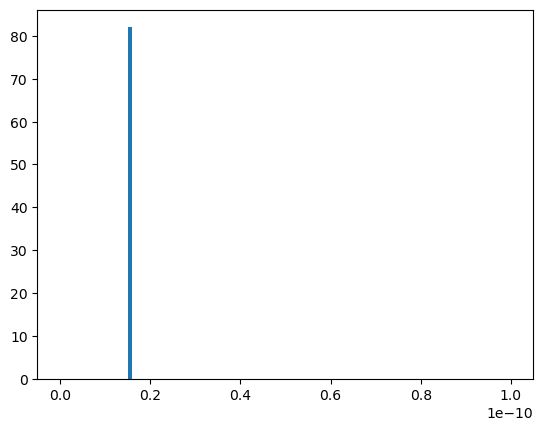

In [8]:
# plot a histogram of np.stack(para_df['para_err'].values)[:, 2]
a=np.stack(para_df['para_err'].values)[:, 2]
a=a[np.isfinite(a)]
fig,ax=plt.subplots()
ax.hist(a,bins=100,range=(0,1e-10))

(array([9.100000e+01, 4.600000e+01, 3.400000e+01, 4.200000e+01,
        3.300000e+01, 2.700000e+01, 2.500000e+01, 3.300000e+01,
        2.500000e+01, 2.400000e+01, 2.100000e+01, 2.100000e+01,
        2.400000e+01, 2.500000e+01, 2.300000e+01, 2.600000e+01,
        2.500000e+01, 2.300000e+01, 2.900000e+01, 2.900000e+01,
        2.000000e+01, 2.700000e+01, 2.500000e+01, 3.400000e+01,
        3.900000e+01, 2.200000e+01, 5.300000e+01, 7.600000e+01,
        2.340000e+02, 1.610000e+03, 9.767000e+03, 4.263800e+04,
        1.307150e+05, 2.851130e+05, 4.516140e+05, 5.370320e+05,
        5.038020e+05, 4.193170e+05, 3.732420e+05, 4.021010e+05,
        4.923690e+05, 6.120170e+05, 7.410390e+05, 8.702490e+05,
        9.697130e+05, 1.004425e+06, 9.675370e+05, 8.820160e+05,
        7.665280e+05, 6.341390e+05, 4.889690e+05, 3.404160e+05,
        2.133480e+05, 1.179810e+05, 5.747400e+04, 2.479100e+04,
        9.285000e+03, 3.348000e+03, 1.227000e+03, 6.310000e+02,
        4.210000e+02, 3.240000e+02, 2.45

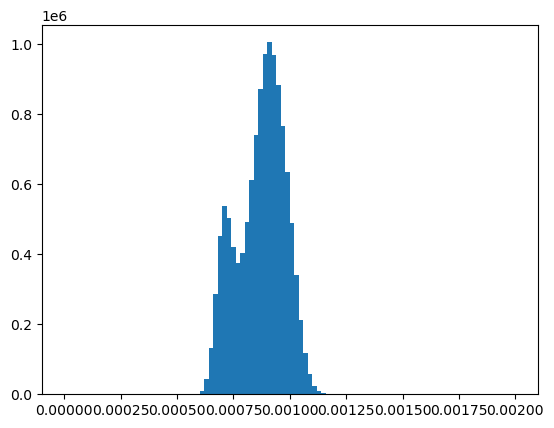

In [13]:
a=np.stack(para_df['para_err'].values)[:, 1]
a=a[np.isfinite(a)]
fig,ax=plt.subplots()
ax.hist(a,bins=100,range=(0,2e-3))

In [10]:
a

array([0.00075072, 0.00073955, 0.00073565, ..., 0.00091243, 0.00095476,
       0.00090223])

In [15]:
a.size

12396828

In [16]:
np.log10(a.size)

7.09331057561999